# South Korea 3Y Monthly Total Exports  

## Introduction
This project aims to develop a predictive model for forecasting South Korea's export volumes over a three-year horizon, utilizing a combination of statistical and machine learning techniques. The project's methodology integrates Exploratory Data Analysis, research-backed approaches, and advanced time series models with hyperparameter tuning to enhance forecast accuracy and robustness.
### Methodology
#### Data and Indicators
To model South Korea's exports, external economic indicators were included, including:

-Taiwan’s Export Data: Often correlated with South Korea's export trends.

-Consumer Price Index (CPI): Reflects inflationary pressures which may influence export prices.

-Exchange Rates: Korean Won to Chinese Yuan (CNY) and US Dollar (USD) rates, which are crucial given South Korea's trade relationships.


#### Statistical Models:
SARIMA and ARIMAX: These models incorporate seasonal patterns and exogenous variables to account for time-dependent and external factors influencing exports.
#### ML Models:
Random Forest and XGBoost: Used for capturing non-linear relationships and interactions between variables, providing robust time series forecasts.

### Limitations
Incomplete Data: There were some challenges in obtaining comprehensive data, particularly for semiconductor exports and full monthly exchange rate data for USD and CNY to WON.

non-stationary Data: Due to time constraint, i was not able to transform macroeconomic indicators into stationary variables. FRED-MD transformations could be applied before feeding the variables to the models in the future.

Backtesting: If givne more time, i would like to conduct back testing on all the models to evaluate the accuracy of models and potentially come up with a most optimal combined model.


Comparison of outputs from different models
![output Image](output.png)

# Exploratory Data Analysis

### Import data and libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb


In [2]:
df = pd.read_csv('Export.csv').iloc[:-2]# reformatted data, only contains monthly export data and external indicators
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Export,Taiwan,CPI,CNY,USD
Date,,,,,
1997-01-01,109.0,96.0,4.44,NaN,NaN
1997-02-01,98.0,78.0,4.44,NaN,NaN
1997-03-01,90.0,74.0,4.44,NaN,NaN
1997-04-01,101.0,87.0,4.44,NaN,NaN
1997-05-01,118.0,89.0,4.44,NaN,NaN
...,...,...,...,...,...
2024-02-01,352.0,183.0,NaN,0.0051,0.000748
2024-03-01,329.0,156.0,NaN,0.0052,0.000743
2024-04-01,271.0,132.0,NaN,0.0052,0.000723


### Timeseries Decomposition 


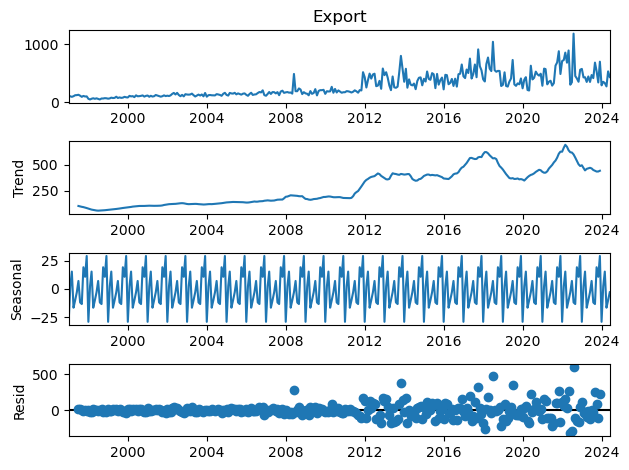

In [3]:
decomposition = seasonal_decompose(df['Export'], model='additive', period=12)  
decomposition.plot()
plt.show()

#### Original Export Trend:
There's an overall increasing trend in exports, but with much more variability and sharper spikes after 2012.
This indicates that exports have not only grown over time but also become more volatile in recent years.
#### Trend:
The trend shows steady growth up until around 2016, after which there’s a flattening and a slight decline before another rise.
This suggests that while exports were generally increasing, there have been periods of stagnation and slight decline, potentially due to economic factors or market saturation.

#### Seasonality: 
There are regular peaks and troughs every year, indicating strong seasonal effects on export levels.
The amplitude of the seasonal effect remains fairly consistent over time, which means that despite the overall growth, the relative seasonal impact on the data has stayed the same.
#### Noise:
There’s an increasing spread in the residuals post-2012, with more significant deviations from the trend and seasonality.
This indicates that in recent years, exports have been subject to more irregular shocks or events that are not captured by the trend or seasonal patterns.


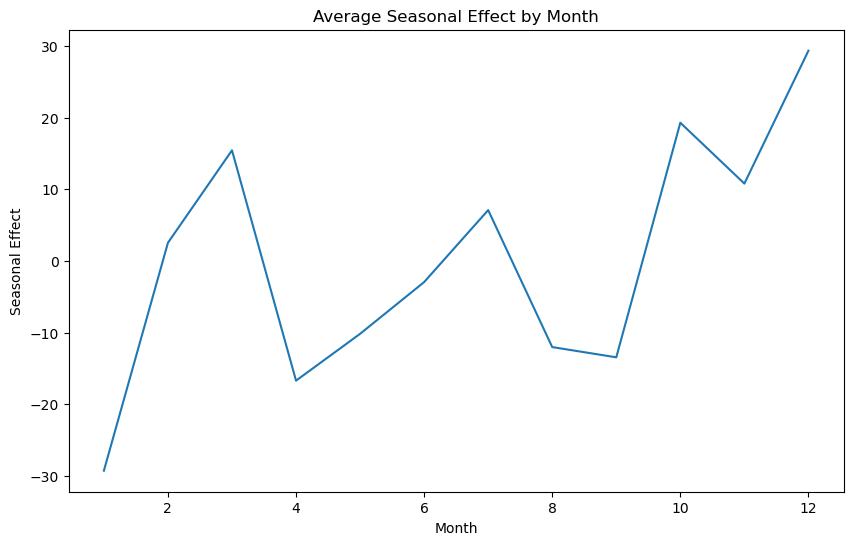

In [4]:
#Drill down for seasonality
seasonal = decomposition.seasonal
seasonal_monthly = seasonal.groupby(seasonal.index.month).mean()
plt.figure(figsize=(10, 6))
seasonal_monthly.plot()
plt.title('Average Seasonal Effect by Month')
plt.xlabel('Month')
plt.ylabel('Seasonal Effect')
plt.show()

#### Peaks in March and Dec
1.Technology Sector: SK is a major exporter of electronics and semiconductors. The positive peaks in March and December could correspond to product launches or restocking cycles in the global tech market, particularly for consumer electronics leading up to the holiday season.

2.Automobile Industry: SK’s automobile exports might be affected by similar seasonal trends, with production ramp-ups in February-March after the New Year holidays and again in December to meet year-end demand.

#### Troughts at Start of Year and Mid year
1.Global Economic Cycles: The dips in the middle of the year could be linked to global summer holidays, when demand for industrial and consumer goods might decline.

2.Lunar New Year Effect: The significant negative effect in January aligns with the Lunar New Year, during which many factories shut down, impacting overall export volumes.

## Literacy

### Factors affecting SK Export in the future

#### 1. Chip exports and other goods
South Korea is one of the leading producers of semiconductors, and the surging global demand, particularly fueled by advancements in AI, has significantly bolstered its export economy. 
In 2023, South Korea's GDP expanded by 2.5%, largely due to strong chip exports. However, the export performance is not uniform across all sectors. For instance, automobile shipments, another key export product, saw a 9.1% Y/Y decline. This suggests that while some sectors are thriving, others are struggling, which can create imbalances in overall export growth.

#### 2. Rising Inflation and Monetary Policy: 
South Korea has been experiencing higher-than-expected inflation, as evidenced by the significant rise in the headline CPI on July 24. This inflationary pressure puts the Bank of Korea (BOK) in a delicate position. While there might be a need to support economic growth through interest rate cuts, the persistent inflation could force the BOK to delay such measures, potentially until deflationary trends appear, which are expected to start in October 2024. Prolonged inflation could lead to higher production costs for South Korean exporters, making their goods less competitive on the global market and potentially slowing export growth.

#### 3. Competition from Taiwan
Taiwan, like South Korea, is a major player in the semiconductor industry, and it also competes in other high-tech sectors such as electronics and machinery. The competition between these two economies is intense, as both aim to dominate the global supply chains in these industries. 

#### 4. Container shipping cirsis
Container shipping is a critical component of South Korea's export strategy, given that much of its trade involves shipping goods by sea. The global shipping industry has faced significant disruptions, particularly due to geopolitical tensions such as the Red Sea crisis. 

Source: Bloomberg Intelligence
-South Korea Country Primer 2024. 
-South Korea Won Reasearch. 
-Taiwan Vs. Korea tech 
-Shipping recovery risk: BI APAC Equity


## Additional Indicators
From this anaysis, I thought of a few indicators to bring in for better prediction

-seasonality 

-semiconductor export (not avaiable, can include for future improvement)

-taiwan export

-Korea CPI

-Won to CNY and USD exchange rate since they are the biggest importers of SK goods


# Benchmark model: SARIMA
to incorporate the Seasonality

/Users/yb/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yb/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                              Export   No. Observations:                  330
Model:             SARIMAX(2, 1, 3)x(2, 0, [], 12)   Log Likelihood               -1871.699
Date:                             Sun, 18 Aug 2024   AIC                           3759.397
Time:                                     13:26:33   BIC                           3789.107
Sample:                                 01-01-1997   HQIC                          3771.283
                                      - 06-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9873      1.357     -0.727      0.467      -3.647       1.673
ar.L2         -0.1540      

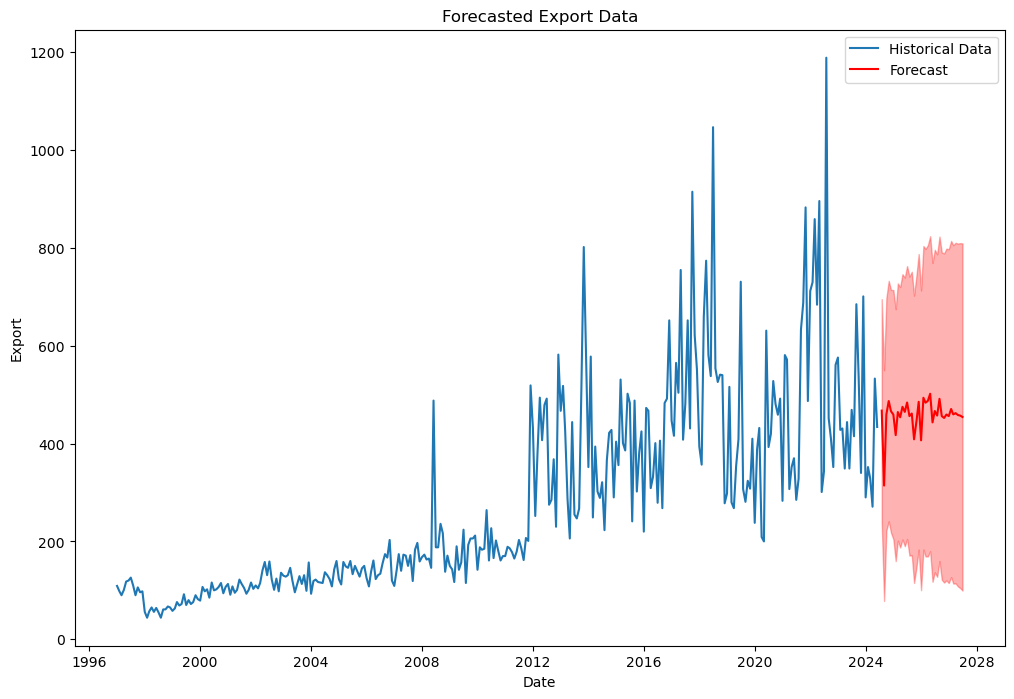

In [24]:
sarima_model = SARIMAX(df['Export'],
                       order=(2,1,3),         # from parameter tuning
                       seasonal_order=(2,0,0, 12), 
                       enforce_stationarity=False,
                       enforce_invertibility=False)


sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

#predict next 36 months
forecast = sarima_result.get_forecast(steps=36)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Export'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Export')
plt.title('Forecasted Export Data')
plt.legend()
plt.show()

In [5]:
#parameter tuning for SARIMAX
auto_model = pm.auto_arima(df['Export'],
                           seasonal=True,
                           m=12,  # Monthly data, seasonal period of 12
                           stepwise=True,
                           trace=True)


print(auto_model.summary())

#frecast
forecast = auto_model.predict(n_periods=36) # next 3 years
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M')
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Export'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Export')
plt.title('Forecasted Export Data')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4060.573, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4213.005, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4141.899, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4067.396, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4211.021, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4063.471, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4064.014, Time=0.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=4056.058, Time=1.97 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4054.045, Time=1.89 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=4052.082, Time=1.07 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=4062.332, Time=0.37 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=4054.073, Time=1.37 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=4058.738, Time=0.44 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=4057.978, Time=0.83 sec
 ARIMA(1,1,1)(2,0,0

KeyboardInterrupt: 

# ARIMAX
it is an extension of SARIMA that allows for more exogenous variables for better prediction 

In [32]:
endog = df['Export']
exog = df[['Taiwan', 'CPI', 'CNY', 'USD']]
exog_int =exog.fillna(method='bfill') 
exog_int = exog_int.fillna(method='ffill')
exog_int = exog_int.interpolate(method='linear')

#interpolate missing value for USD and CNY

model = SARIMAX(endog, exog=exog_int, order=(2,1,3), seasonal_order=(2, 0, 0, 12))
model_fit = model.fit(disp=False)
future_exog = exog_int.tail(36)   #prediction for the next 36 months
forecast_arimax = model_fit.predict(start=len(endog), end=len(endog) + 36 - 1, exog=future_exog)

/Users/yb/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yb/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/yb/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
predicted_arimax= forecast_arimax.values 
predicted_arimax

array([558.52842735, 430.24516361, 531.58575321, 549.42122925,
       529.68385346, 539.55343902, 483.35982984, 528.37528745,
       505.65365444, 498.24300357, 519.2118251 , 499.9731521 ,
       470.71717182, 445.64719063, 360.05494328, 398.32616961,
       490.21130998, 462.57711735, 537.65811277, 481.95019923,
       491.22689153, 477.37015703, 437.58364116, 480.64706352,
       487.77534462, 480.9082461 , 433.02527673, 434.18271757,
       477.06709442, 458.3868468 , 461.45529437, 461.39607103,
       450.45404727, 423.59664921, 425.81207354, 426.03397953])

# ML Models

ML models with 3 year horizon
#### models and reasons
rf: able to handle high dimensional data with feature importance. handle null values well 

xgb: able to capture complex interactions and non-linearities can be beneficial when dealing with high-dimensional data and strong seasonality

In [13]:
horizon = 36 # 3 year horizon

### timeseries to supervised learning
In order to prevent data leakage, when training the model, data from X years ago shoudl be used to predict the current X years horizon. Through creating lags, timeseries problem can be converted to supervised learning problems

e.g. for 1 period forward forecast

![Train-Test Image](train-test-split.png)

In [ ]:
#Add lags
def create_lags(df, lags, columns):
    for col in columns:
        for lag in range(1, lags + horizon+1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df
def append_nan_rows(df, n):
    nan_rows = pd.DataFrame(np.nan, index=range(n), columns=df.columns)
    df_extended = pd.concat([df, nan_rows], ignore_index=True)
    
    return df_extended
df_na = df.reset_index(drop=False)
df_na = append_nan_rows(df_na, horizon)
df_lagged = create_lags(df_na, lags=6, columns=['Export', 'Taiwan', 'CPI', 'CNY', 'USD']) 
df_lagged

In [15]:
# extend date column
def extend_date_column(df, date_column='Date'):
    df[date_column] = pd.to_datetime(df[date_column])
    last_valid_date = df[date_column].dropna().iloc[-1]
    first_nan_idx = df[date_column].first_valid_index()
    date_sequence = pd.date_range(start=last_valid_date, periods=len(df) - df[date_column].notna().sum() + 1, freq='MS')[1:]
    #fill NaN values with the generated date sequence
    df.loc[df[date_column].isna(), date_column] = date_sequence
    
    return df

#df_lagged['Date'] = df['Date']
df_lagged = extend_date_column(df_lagged)

#add seasonality
df_lagged.set_index('Date', inplace=True)
df_lagged['month'] = df_lagged.index.month
df_lagged['year'] = df_lagged.index.year
df_lagged


/var/folders/ln/3gq8jd257w92_5vb3dwx5jzr0000gn/T/ipykernel_2157/132429406.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged['month'] = df_lagged.index.month
/var/folders/ln/3gq8jd257w92_5vb3dwx5jzr0000gn/T/ipykernel_2157/132429406.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged['year'] = df_lagged.index.year


,Export,Taiwan,CPI,CNY,USD,Export_lag1,Export_lag2,Export_lag3,Export_lag4,Export_lag5,...,USD_lag35,USD_lag36,USD_lag37,USD_lag38,USD_lag39,USD_lag40,USD_lag41,USD_lag42,month,year
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,109.0,96.0,4.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1997
1997-02-01,98.0,78.0,4.44,NaN,NaN,109.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1997
1997-03-01,90.0,74.0,4.44,NaN,NaN,98.0,109.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1997
1997-04-01,101.0,87.0,4.44,NaN,NaN,90.0,98.0,109.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1997
1997-05-01,118.0,89.0,4.44,NaN,NaN,101.0,90.0,98.0,109.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000743,0.000748,0.000749,0.000772,0.000771,0.000740,0.000739,0.000754,2,2027
2027-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000723,0.000743,0.000748,0.000749,0.000772,0.000771,0.000740,0.000739,3,2027
2027-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000723,0.000723,0.000743,0.000748,0.000749,0.000772,0.000771,0.000740,4,2027


In [16]:
#train-test split
y_train = df['Export'].iloc[horizon:]
X_lagged = df_lagged.drop(columns=['Export'])
X_train = X_lagged.iloc[horizon:-horizon]
X_test = X_lagged.iloc[-horizon:]


In [20]:
#print(y_train)
#print(X_train)
#print(X_test)

            Taiwan   CPI     CNY       USD  Export_lag1  Export_lag2  \
Date                                                                   
2000-01-01    83.0  2.26     NaN       NaN         82.0         90.0   
2000-02-01    83.0  2.26     NaN       NaN         79.0         82.0   
2000-03-01    86.0  2.26     NaN       NaN        107.0         79.0   
2000-04-01    82.0  2.26     NaN       NaN         98.0        107.0   
2000-05-01    91.0  2.26     NaN       NaN        102.0         98.0   
...            ...   ...     ...       ...          ...          ...   
2024-02-01   183.0   NaN  0.0051  0.000748        290.0        701.0   
2024-03-01   156.0   NaN  0.0052  0.000743        352.0        290.0   
2024-04-01   132.0   NaN  0.0052  0.000723        329.0        352.0   
2024-05-01   158.0   NaN  0.0052  0.000723        271.0        329.0   
2024-06-01   158.0   NaN     NaN  0.000724        533.0        271.0   

            Export_lag3  Export_lag4  Export_lag5  Export_lag6 

In [17]:
#RF with hyperpara tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto' and added None
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,  param_distributions=param_grid,  n_iter=100,  
    cv=3,  # 3-fold cross-validation
    verbose=2, 
    random_state=42, n_jobs=-1   
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50

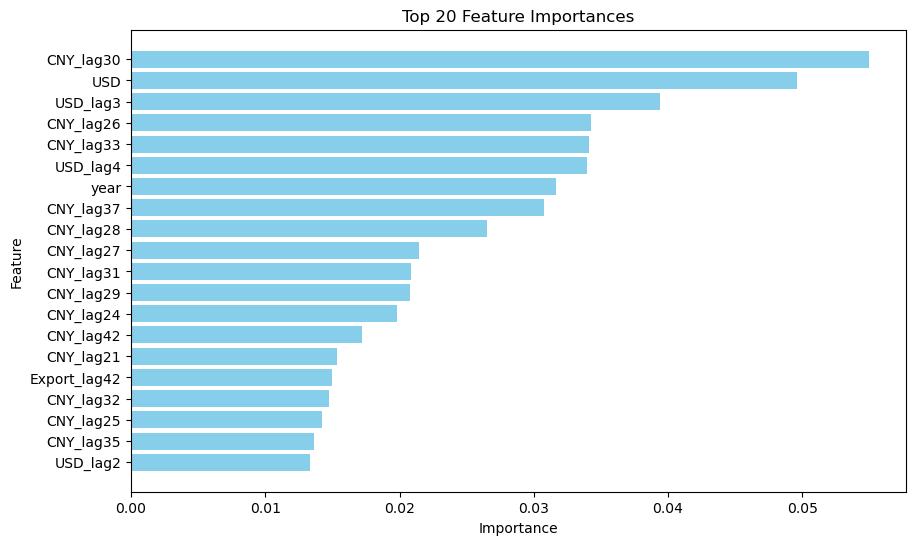

In [18]:
# plot top 20 most importanct features
importances = best_rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_20_importance_df = importance_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis() 
plt.show()


In [27]:
y_pred

array([414.17363253, 422.78875851, 400.79994603, 417.07907434,
       421.23183181, 403.34073585, 383.58386491, 410.1835126 ,
       394.95248674, 392.75865901, 381.54310373, 391.41133045,
       375.88601449, 388.65129576, 392.70620793, 385.41892779,
       386.17374056, 375.18365879, 359.75354226, 363.16409227,
       345.58805755, 362.01450017, 334.32641184, 320.97512282,
       308.62683686, 277.8301978 , 266.23014377, 263.15679609,
       243.45452553, 233.90955764, 226.33296942, 215.68133455,
       200.01247344, 195.42092655, 185.37535145, 188.7030578 ])

In [35]:
#xgb with hyperpara tuning
dtrain = xgb.DMatrix(X_train, label=y_train)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=xg_reg, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, 
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_xgb= best_model.predict(X_test)



Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


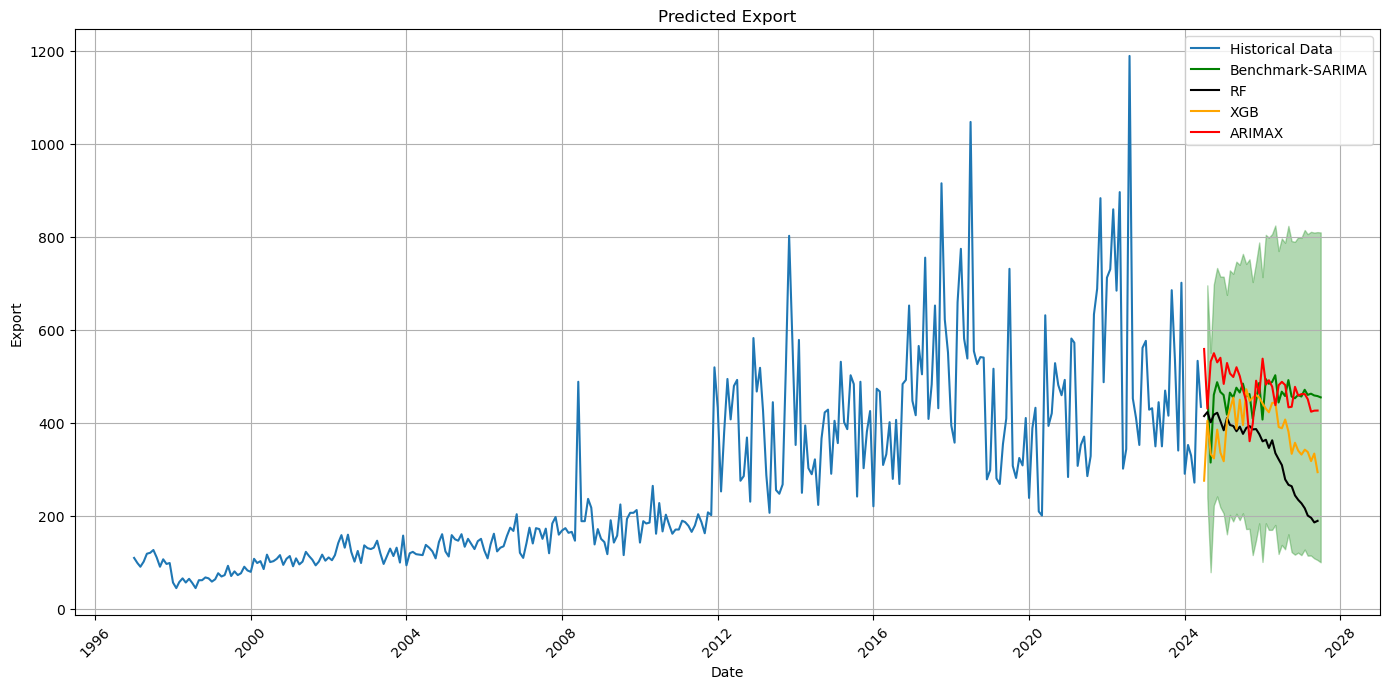

In [44]:
#plot the prediction trend

df_date=df.reset_index(drop= False)
plt.figure(figsize=(14, 7))
forecast = sarima_result.get_forecast(steps=36)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=36, freq='M')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()
pred_date= X_test.reset_index(drop= False)
pred_sarima=forecast_values.values
predictions_df = pd.DataFrame({
    'Date': pred_date['Date'],
    'predicted_rf': y_pred ,
    'pred_xgb': y_pred_xgb,
    'pred_arima': predicted_arimax
    ,'pred_sarima':pred_sarima
})
plt.plot(df.index, df['Export'], label='Historical Data')
plt.plot(forecast_index, forecast_values, label='Benchmark-SARIMA', color='green')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='green', alpha=0.3)


plt.plot(predictions_df['Date'], predictions_df['predicted_rf'], label='RF', color='black')
plt.plot(predictions_df['Date'], predictions_df['pred_xgb'], label='XGB', color='orange')
plt.plot(predictions_df['Date'], predictions_df['pred_arima'], label='ARIMAX', color='red')

plt.xlabel('Date')
plt.ylabel('Export')
plt.title('Predicted Export')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


In [46]:
predictions_df.to_csv('output.csv', index=False)
predictions_df

,Date,predicted_rf,pred_xgb,pred_arima,pred_sarima
0,2024-07-01,414.173633,275.111359,558.528427,467.479418
1,2024-08-01,422.788759,404.227997,430.245164,314.171111
2,2024-09-01,400.799946,332.455902,531.585753,459.728274
3,2024-10-01,417.079074,323.052979,549.421229,487.047083
4,2024-11-01,421.231832,384.935699,529.683853,466.125273
5,2024-12-01,403.340736,335.549469,539.553439,459.423214
6,2025-01-01,383.583865,316.955963,483.359830,417.325108
7,2025-02-01,410.183513,406.125305,528.375287,464.555087
8,2025-03-01,394.952487,428.761993,505.653654,453.873615
9,2025-04-01,392.758659,453.895477,498.243004,475.216566
